In [ ]:
pip install fuzzywuzzy

In [172]:
import json
import pandas as pd
import geopandas as gpd
from fuzzywuzzy import fuzz

with open('Data/unsupervised_places_interactions_ch3.json', 'r') as f:
    data = json.load(f)

json_df = pd.read_json('Data/unsupervised_places_interactions_ch3.json')

#display(data)
display(json_df)



,place,interaction,description
0,Jerusalem,visited,Visited and explored various localities in and...
1,Bethlehem,mentioned,Plans to visit Bethlehem and reflect on the bi...
2,Bethany,mentioned,Intends to visit Bethany and read about the re...
3,Gethsemane,mentioned,Looks forward to visiting Gethsemane to contem...
4,Calvary,mentioned,Aims to visit Calvary and reflect on the story...
5,Mount Olivet,mentioned,Anticipates visiting Mount Olivet to consider ...
6,Zion,observed,"Observed the hill of Zion, a significant locat..."
7,Akra,observed,Noted the hill of Akra while exploring Jerusalem.
8,Bezetha,observed,"Bezetha, one of the hills on which Jerusalem i..."
9,Moriah,observed,"Observed Moriah, another hill forming part of ..."


In [173]:
# Replace this with the path to your .shp file
shapefile_path = 'Data/landmarks_names.shp'

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Now you can work with the GeoDataFrame 'gdf' as you would with a Pandas DataFrame
gdf  # This will print the first few rows of the GeoDataFrame

#gdf.plot("area", legend=True)

,id,English,Arabic,Arabic_2,German,English_2,Hebrew,geometry
0,None,Storks Tower,Burj Laklak,None,None,None,None,POINT (35.23671 31.78368)
1,None,St. Stephen's Gate,Bâb Sitti Maryam,Bāb Sitti Marjam,Stephansthor,None,None,POINT (35.23693 31.78085)
2,None,Gate of the Tribes\t\t\t\t,Bâb al Asbât\t,None,None,None,None,POINT (35.23693 31.78026)
3,None,Solomon's Throne,None,None,None,None,None,POINT (35.23706 31.77941)
4,None,Golden Gate,Bâb al Taûbe',None,None,None,None,POINT (35.23707 31.77897)
...,...,...,...,...,...,...,...,...
155,None,German Colony,None,None,None,None,None,POINT (35.22056 31.76486)
156,None,Railway Station,None,None,None,None,None,POINT (35.22457 31.76697)
157,None,Chapel of the Ascension,None,None,None,None,None,POINT (35.24499 31.77891)
158,None,German Hospice,None,None,None,None,None,POINT (35.24939 31.78678)


In [174]:
# Function to perform fuzzy matching
def fuzzy_match(toponym1, toponym2):
    return fuzz.token_set_ratio(str(toponym1), str(toponym2))

# Dictionary to store the best match for each place in json_df
best_matches = {}

# Iterate through rows in json_df and find matches in gdf
for index1, row1 in json_df.iterrows():
    place_in_json = row1['place']

    # Initialize variables to track the best match for the current place_in_json
    best_match_score = 0
    best_match_place = None
    best_match_geometry = None

    # Iterate through rows in gdf
    for index2, row2 in gdf.iterrows():
        # Iterate through language columns in gdf
        for lang_column in ["English", "Arabic", "English_2", "Arabic_2", "German", "Hebrew"]:
            place_in_gdf = row2[lang_column]

            # Skip if the language column is None
            if pd.notnull(place_in_gdf):
                similarity_score = fuzzy_match(place_in_json, place_in_gdf)
                
                # Update the best match if the current match has a higher similarity score
                if similarity_score >= 80 and similarity_score > best_match_score:
                    best_match_score = similarity_score
                    best_match_place = place_in_gdf
                    best_match_geometry = row2['geometry']

    # Store the best match for the current place_in_json in the dictionary
    if best_match_place is not None:
        best_matches[place_in_json] = {
            'place_in_json': place_in_json,
            'place_in_gdf': best_match_place,
            'similarity_score': best_match_score,
            'geometry': best_match_geometry,
            'description': row1['description']
        }

# Create a dataframe from the dictionary of best matches
best_matches_df = pd.DataFrame(list(best_matches.values()))

# Convert the best_matches_df to a GeoDataFrame
best_matches_gdf = gpd.GeoDataFrame(best_matches_df, geometry='geometry')

# Display or further process the best_matches_gdf as needed
print(best_matches_gdf)


                   place_in_json                   place_in_gdf  \
0                     Gethsemane                     Gethsemane   
1                           Zion                      Zion Gate   
2                  Damascus Gate        Damascus Gate\t\t\t\t\t   
3             St. Stephen's Gate             St. Stephen's Gate   
4                    Golden Gate                    Golden Gate   
5                      Zion Gate                      Zion Gate   
6                     Jaffa Gate                     Jaffa Gate   
7                 Pool of Siloam                 Pool of Siloam   
8            Church of St. James             Church of St. Anne   
9                  Tomb of David                   David's Tomb   
10                  Via Dolorosa                   Via Dolorosa   
11            Church of St. Anne             Church of St. Anne   
12  Church of the Holy Sepulchre   Church of the Holy Sepulchre   
13        Church of Flagellation  Monastery of the Flagellatio

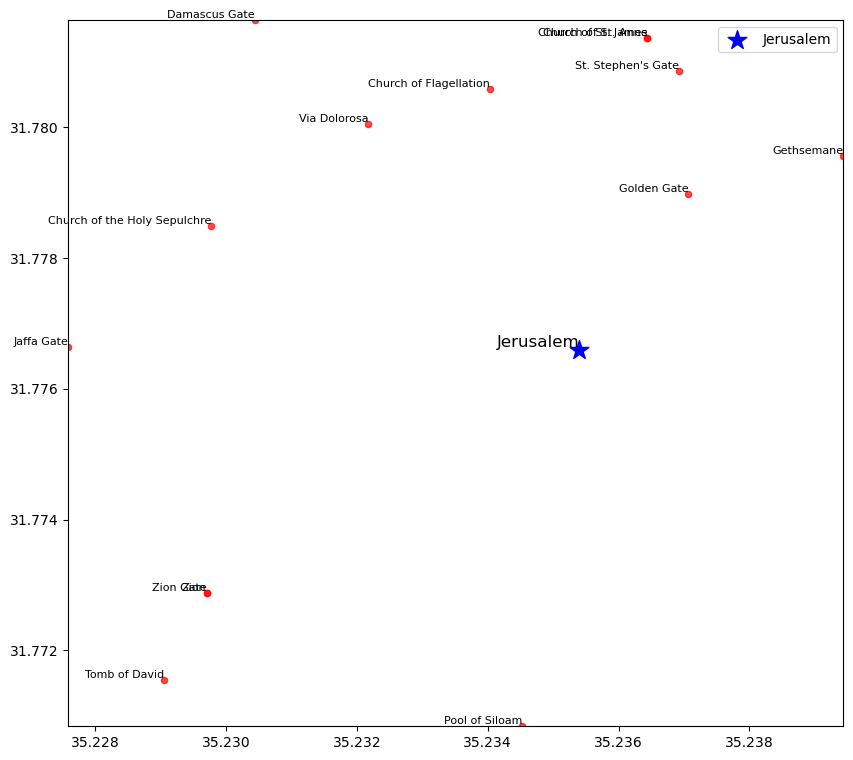

In [175]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create a GeoDataFrame for Jerusalem
jerusalem_point = gpd.GeoDataFrame({'place_in_json': ['Jerusalem']},
                                   geometry=[Point(35.2354, 31.7766)])  # Coordinates for Jerusalem

# Get the bounding box of the best_matches_gdf
xmin, ymin, xmax, ymax = best_matches_gdf.total_bounds

# Set up the map extent
#buffer_distance = 0.001  # degrees of longitude and latitude to include around Jerusalem
#xmin, ymin, xmax, ymax = jerusalem_point.total_bounds
#xmin -= buffer_distance
#ymin -= buffer_distance
#xmax += buffer_distance
#ymax += buffer_distance

# Plot the best_matches_gdf on a map centered around the bounding box
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Plot the map background (optional)
#gpd.datasets.get_path('naturalearth_lowres') provides a world map shapefile
# You may need to download the world shapefile or replace it with another local shapefile
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the best_matches_gdf points with reduced marker size
best_matches_gdf.plot(ax=ax, color='red', marker='o', markersize=20, alpha=0.7)

# Plot the Jerusalem point with a larger marker
jerusalem_point.plot(ax=ax, color='blue', marker='*', markersize=200, label='Jerusalem')

# Add labels with adjusted positions
for x, y, label in zip(best_matches_gdf.geometry.x, best_matches_gdf.geometry.y, best_matches_gdf['place_in_json']):
    ax.text(x, y, label, fontsize=8, ha='right', va='bottom', color='black')

# Add label for Jerusalem
ax.text(jerusalem_point.geometry.x[0], jerusalem_point.geometry.y[0], 'Jerusalem', fontsize=12, ha='right', va='bottom', color='black')

# Show the plot
plt.legend()
plt.show()


In [176]:
conda install nbformat

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
/ DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/osx-arm64/current_repodata.json HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/osx-arm64/current_repodata.json HTTP/1.1" 304 0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updat

In [177]:
display(best_matches_gdf)

,place_in_json,place_in_gdf,similarity_score,geometry,description
0,Gethsemane,Gethsemane,100,POINT (35.23944 31.77956),Looks forward to visiting Gethsemane to contem...
1,Zion,Zion Gate,100,POINT (35.22970 31.77287),"Observed the hill of Zion, a significant locat..."
2,Damascus Gate,Damascus Gate\t\t\t\t\t,100,POINT (35.23044 31.78164),"Visited the Damascus Gate, located midway alon..."
3,St. Stephen's Gate,St. Stephen's Gate,100,POINT (35.23693 31.78085),"Visited St. Stephen's Gate, facing Mount Olivet."
4,Golden Gate,Golden Gate,100,POINT (35.23707 31.77897),Observed the now closed Golden Gate of the Tem...
5,Zion Gate,Zion Gate,100,POINT (35.22970 31.77287),"Visited Zion Gate, located near the southern p..."
6,Jaffa Gate,Jaffa Gate,100,POINT (35.22759 31.77663),"Visited Jaffa Gate, situated near the west of ..."
7,Pool of Siloam,Pool of Siloam,100,POINT (35.23453 31.77084),Referred to the Pool of Siloam as part of Jeru...
8,Church of St. James,Church of St. Anne,86,POINT (35.23644 31.78137),"Visited the Church of St. James, related to th..."
9,Tomb of David,David's Tomb,91,POINT (35.22906 31.77155),Visited the Tomb of David and associated relig...


In [206]:
import plotly.express as px
import plotly.graph_objs as go
import math


# Import other necessary libraries like contextily or folium for the map



best_matches_gdf['longitude'] = best_matches_gdf.geometry.x
best_matches_gdf['latitude'] = best_matches_gdf.geometry.y

fig = go.Figure()


# Assuming 'df' is your GeoDataFrame with coordinates and place names
fig = px.scatter_geo(best_matches_gdf, lat='latitude', lon='longitude', hover_name='description', text='place_in_json')
fig.update_traces(textposition='bottom center')



# Add lines and triangle annotations
for i in range(len(best_matches_gdf) - 1):
    lon1, lat1 = best_matches_gdf['longitude'].iloc[i], best_matches_gdf['latitude'].iloc[i]
    lon2, lat2 = best_matches_gdf['longitude'].iloc[i+1], best_matches_gdf['latitude'].iloc[i+1]

    fig.add_annotation(
    xref="x",
    yref="y",
    x=lon2,
    y=lat2,
    text="Pino",
    # If axref is exactly the same as xref, then the text's position is
    # absolute and specified in the same coordinates as xref.
    axref="x domain",
    # The same is the case for yref and ayref, but here the coordinates are data
    # coordinates
    ayref="y",
    ax=lon1,
    ay=lat2,
    arrowhead=2,
    )

    
 


fig.update_geos(fitbounds="locations")
fig.update_layout(
    geo=dict(
        showframe=True,  # Show frame around the map
        showcoastlines=True,  # Show coastlines
        showland=True,  # Show land
        landcolor="LightGreen",
        countrycolor="DarkBlue",
        coastlinecolor="RebeccaPurple",
        projection=dict(type="equirectangular"),
        #lonaxis=dict(range=[min_lon - lon_expand, max_lon + lon_expand]), 
        #lataxis=dict(range=[min_lat - lat_expand, max_lat + lat_expand])
    )
)

# Customize your map background here

fig.show()

In [179]:
import geopandas as gpd
import plotly.graph_objs as go
import math

# Assuming 'gdf' is your GeoDataFrame
best_matches_gdf['longitude'] = best_matches_gdf['geometry'].x
best_matches_gdf['latitude'] = best_matches_gdf['geometry'].y

# Initialize a figure
fig = go.Figure()

# Add scatter plot for points
fig.add_trace(go.Scattergeo(
    lon=best_matches_gdf['longitude'],
    lat=best_matches_gdf['latitude'],
    mode='markers',
    hoverinfo='text'
))

# Function to calculate rotation angle
def calculate_angle(lon1, lat1, lon2, lat2):
    angle = math.atan2(lat2 - lat1, lon2 - lon1)
    return math.degrees(angle)

# Add lines and triangle annotations
for i in range(len(best_matches_gdf) - 1):
    lon1, lat1 = best_matches_gdf['longitude'].iloc[i], best_matches_gdf['latitude'].iloc[i]
    lon2, lat2 = best_matches_gdf['longitude'].iloc[i+1], best_matches_gdf['latitude'].iloc[i+1]
    
    # Draw line
    fig.add_trace(
        go.Scattergeo(
            lon=[lon1, lon2],
            lat=[lat1, lat2],
            mode='lines',
            line=dict(width=2, color='blue'),
        )
    )
    
    # Calculate angle for the arrow
    angle = calculate_angle(lon1, lat1, lon2, lat2)
    
    # Add rotated triangle (arrow)
    fig.add_annotation(
        x=lon2, y=lat2,
        xref="x", yref="y",
        text="▲", # Triangle symbol as arrow
        showarrow=False,
        font=dict(size=12),
        xanchor="center",
        yanchor="middle",
        align="center",
        textangle=angle
    )

# Update layout
fig.update_layout(
    title='Journey Plot',
    showlegend=False,
    geo=dict(
        scope='world',
        projection_type='equirectangular',
    ),
)

fig.show()


In [203]:
import plotly.express as px
import plotly.graph_objs as go
import geopandas as gpd
import math

# Assuming 'best_matches_gdf' is your GeoDataFrame
best_matches_gdf['longitude'] = best_matches_gdf.geometry.x
best_matches_gdf['latitude'] = best_matches_gdf.geometry.y

fig.update_layout(xaxis=dict(domain=[0, 0.5]), yaxis=dict(domain=[0.25, 0.75]))

# Create initial scatter plot
fig = px.scatter_geo(best_matches_gdf, lat='latitude', lon='longitude', hover_name='description', text='place_in_json')
fig.update_traces(textposition='bottom center')

# Add lines and annotations
for i in range(len(best_matches_gdf) - 1):
    lon1, lat1 = best_matches_gdf['longitude'].iloc[i], best_matches_gdf['latitude'].iloc[i]
    lon2, lat2 = best_matches_gdf['longitude'].iloc[i+1], best_matches_gdf['latitude'].iloc[i+1]

    # Adding lines
    fig.add_trace(go.Scattergeo(
        lon=[lon1, lon2],
        lat=[lat1, lat2],
        mode='lines',
        line=dict(width=2, color='blue')
    ))

    # Adding annotations
    fig.add_annotation(
        x=lon2,
        y=lat2,
        ax=lon1,
        ay=lat1,
        xref="paper",
        yref="paper",
        axref="x",
        ayref="y",
        showarrow=True,
        arrowhead=2,
    )

# Update layout
fig.update_layout(
    geo=dict(
        showframe=True,
        showcoastlines=True,
        showland=True,
        landcolor="LightGreen",
        countrycolor="DarkBlue",
        coastlinecolor="RebeccaPurple",
        projection=dict(type="equirectangular")
    )
)
fig.update_geos(fitbounds="locations")

# Show the figure
fig.show()


In [280]:
import plotly.express as px
import plotly.graph_objs as go
import geopandas as gpd
import math

# Assuming 'best_matches_gdf' is your GeoDataFrame
best_matches_gdf['longitude'] = best_matches_gdf.geometry.x
best_matches_gdf['latitude'] = best_matches_gdf.geometry.y


# Create initial scatter plot
fig = px.scatter_geo(best_matches_gdf, lat='latitude', lon='longitude', hover_name='description', text='place_in_gdf')
fig.update_traces(textposition='bottom center')

mid_lons = []
mid_lats = []

def calculate_angle(lon1, lat1, lon2, lat2):
    angle = math.atan2(lat2 - lat1, lon2 - lon1)
    return math.degrees(angle)

def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Difference in coordinates
    d_lon = lon2 - lon1

    # Calculate bearing
    x = math.sin(d_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(d_lon))

    # Obtain bearing in degrees
    bearing = math.degrees(math.atan2(x, y))

    # Normalize the bearing
    bearing = (bearing + 360) % 360

    return bearing


# Add lines and annotations
for i in range(len(best_matches_gdf) - 1):
    lon1, lat1 = best_matches_gdf['longitude'].iloc[i], best_matches_gdf['latitude'].iloc[i]
    lon2, lat2 = best_matches_gdf['longitude'].iloc[i+1], best_matches_gdf['latitude'].iloc[i+1]

    angle = 0
    mid_lon = (lon1 + lon2) / 2
    mid_lat = (lat1 + lat2) / 2
    angle = calculate_angle(lon1, lat1, lon2, lat2)
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)

    # Adding lines
    fig.add_trace(go.Scattergeo(
        lon=[lon1, lon2],
        lat=[lat1, lat2],
        mode='lines+text',
        name=i+1,
        line=dict(width=2, color='blue'),
        hovertext=best_matches_gdf['description'].iloc[i],
        opacity=1,
        showlegend=False
        
        )
    )

    fig.add_trace(go.Scattergeo(
        lon=[mid_lon],
        lat=[mid_lat],
        mode='text+markers',
        name=i+1,
        hovertext=best_matches_gdf['description'].iloc[i],
        opacity=1,
        showlegend=False,


        text="",  # Assuming 'label' is a column with labels for lines
        textposition='middle center',
        textfont=dict(
        size=14,
        color='red',  # Change to your preferred color
        family='Arial'  # Specify font family and style
    ),
        
        marker=dict(
        color='black',  # Black background
        opacity=1,
        size=14,
        symbol='arrow-wide',
        angle=bearing,
    ),
        )
    )

    #mid_lons.append(mid_lon)
    #mid_lats.append(mid_lat)

    #px.scatter(mid_lats, mid_lons, text='pino')
    








fig.update_geos(fitbounds="locations")

# Show the figure
fig.show()
